In [1]:
# Previously read a readme about game rule and turn simulation used here.
# In this file I will use the information from player, challenge and simulation turn result 
# just as initial data to choose and train model
# So here we
# - Import and explore data
# - Get its ready for training
# - Explain criterion choice
# - Create pipeline to choose model
# - Make a gridsearch for best parameters
# - Train and save final model

In [2]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.utils import class_weight

#
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Importing the self-written modules
from modules.data_simulation import InitialData

# Get a dataset with some combination of player cards and choosed challenge card with all 
# characteeristics and simulated answer if trying this challenge worth it or not.
# For details about simulation - module data_simulation - Turn - simulate_turn
data = InitialData()
turns = data.define_turns(8000, if_target=True)

In [4]:
# Main information about features. Happily don't have missing values
turns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Игрок                8000 non-null   int64 
 1   Происхождение        8000 non-null   object
 2   Руна_1               8000 non-null   object
 3   Руна_2               8000 non-null   object
 4   Стремление           8000 non-null   object
 5   Опция                8000 non-null   object
 6   Судьба               8000 non-null   object
 7   Цель_1               8000 non-null   object
 8   Цель_2               8000 non-null   object
 9   Цель_3               8000 non-null   object
 10  Опыт                 8000 non-null   int64 
 11  Способность          8000 non-null   object
 12  Исп. доп. руны       8000 non-null   bool  
 13  Исп. руны тьмы       8000 non-null   bool  
 14  Испытание            8000 non-null   object
 15  Основная руна        8000 non-null   object
 16  Дополн

In [5]:
# Example of how our information looks like. Most columns are categorical
turns.head()

,Игрок,Происхождение,Руна_1,Руна_2,Стремление,Опция,Судьба,Цель_1,Цель_2,Цель_3,Опыт,Способность,Исп. доп. руны,Исп. руны тьмы,Испытание,Основная руна,Дополнительная руна,Сложность,Стоит ли пробовать
0,17564,Чужестранец,Телосложение,Мудрость,Жаждущий знаний,Интеллект,Драконорожденный,Телосложение,Обаяние,Нет,3,Интеллект,False,False,"Украсть, чтобы выжить",Ловкость,Телосложение,4,0
1,12232,Оруженосец,Ловкость,Сила,Жаждущий знаний,Интеллект,Коварный злодей,Сила,Ловкость,Интеллект,1,Сила,True,False,Преуспеть в учебе,Интеллект,Мудрость,4,0
2,14593,Фермер,Сила,Мудрость,Ученик мастера,Сила,Великий завоеватель,Сила,Ловкость,Телосложение,3,Ловкость,False,True,"Украсть, чтобы выжить",Ловкость,Телосложение,4,0
3,5855,Подмастерье,Ловкость,Интеллект,В поисках истины,Мудрость,Великий завоеватель,Сила,Ловкость,Телосложение,3,Сила,False,True,Склонность к светлой магии,Интеллект,Обаяние,4,0
4,17137,Чужестранец,Телосложение,Мудрость,Прирожденный лидер,Обаяние,Народный заступник,Сила,Мудрость,Нет,0,Нет,False,False,Возвести укрепления,Сила,Интеллект,4,0


<Axes: xlabel='Стоит ли пробовать', ylabel='count'>

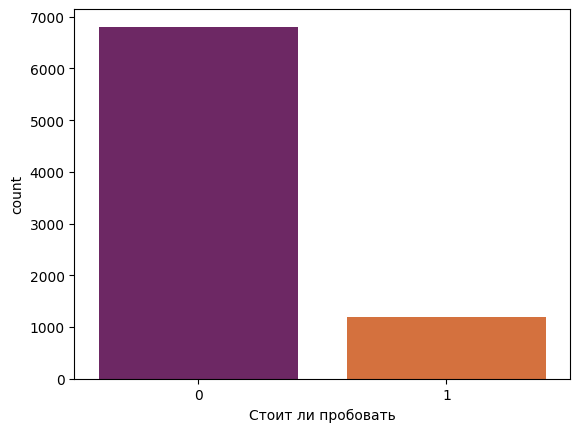

In [6]:
# Guess that we deal with unbalanced data - That's true! 
sns.countplot(data=turns, x='Стоит ли пробовать', palette='inferno') 

In [7]:
# Don't have anything for cleaning data, because all our game turns are simulated. 
# For this purpose data were cleaned and explored before. Let's just explore them a bit 
# more not to go back and so we may know with what we are dealing

In [8]:
# With so unbalanced data, what we will see in positive outcome only
turns[turns['Стоит ли пробовать'] == 1][:10]

,Игрок,Происхождение,Руна_1,Руна_2,Стремление,Опция,Судьба,Цель_1,Цель_2,Цель_3,Опыт,Способность,Исп. доп. руны,Исп. руны тьмы,Испытание,Основная руна,Дополнительная руна,Сложность,Стоит ли пробовать
7,7796,Школяр,Мудрость,Интеллект,Сорвиголова,Ловкость,Драконорожденный,Телосложение,Обаяние,Нет,1,Нет,False,True,Изгнать призрака,Мудрость,Обаяние,3,1
9,14573,Фермер,Сила,Мудрость,Ученик мастера,Сила,Народный заступник,Сила,Мудрость,Нет,2,Сила,False,True,Скрыться от преследователей,Ловкость,Мудрость,3,1
31,10244,Моряк,Сила,Интеллект,Поклявшийся защишать,Телосложение,Коварный злодей,Сила,Ловкость,Интеллект,3,Нет,False,True,Возвести укрепления,Сила,Интеллект,4,1
63,6700,Подмастерье,Ловкость,Интеллект,Рожденный в рубашке,Нет,Драконорожденный,Телосложение,Обаяние,Нет,1,Телосложение,False,True,Скрыться от преследователей,Ловкость,Мудрость,3,1
74,14625,Фермер,Сила,Мудрость,Ученик мастера,Сила,Коварный злодей,Сила,Ловкость,Интеллект,2,Ловкость,True,True,Найти пропавшее дитя,Мудрость,Сила,4,1
76,12180,Оруженосец,Ловкость,Сила,Жаждущий знаний,Интеллект,Народный заступник,Сила,Мудрость,Нет,3,Сила,False,True,Найти пропавшее дитя,Мудрость,Сила,4,1
109,924,Нищий,Ловкость,Обаяние,Жаждущий знаний,Интеллект,Великий завоеватель,Сила,Ловкость,Телосложение,0,Телосложение,False,False,Выучиться на шпиона,Обаяние,Ловкость,3,1
114,17515,Чужестранец,Телосложение,Мудрость,Сорвиголова,Ловкость,Верховный арканист,Интеллект,Мудрость,Нет,2,Интеллект,True,True,Отыскать место силы,Мудрость,Ловкость,4,1
117,15999,Воришка,Ловкость,Телосложение,Ученик мастера,Сила,Верховный арканист,Интеллект,Мудрость,Нет,2,Ловкость,True,True,Скрыться от преследователей,Ловкость,Мудрость,3,1
119,10864,Моряк,Сила,Интеллект,Жаждущий знаний,Интеллект,Коварный злодей,Сила,Ловкость,Интеллект,3,Сила,True,True,Стать завзятым бойцом,Сила,Ловкость,4,1


In [9]:
# For some rows any of cards and its characteristics are the same. Its have diffenece 
# in column Опыт, but this doesn't affect the result. Let's look at this a bit closer

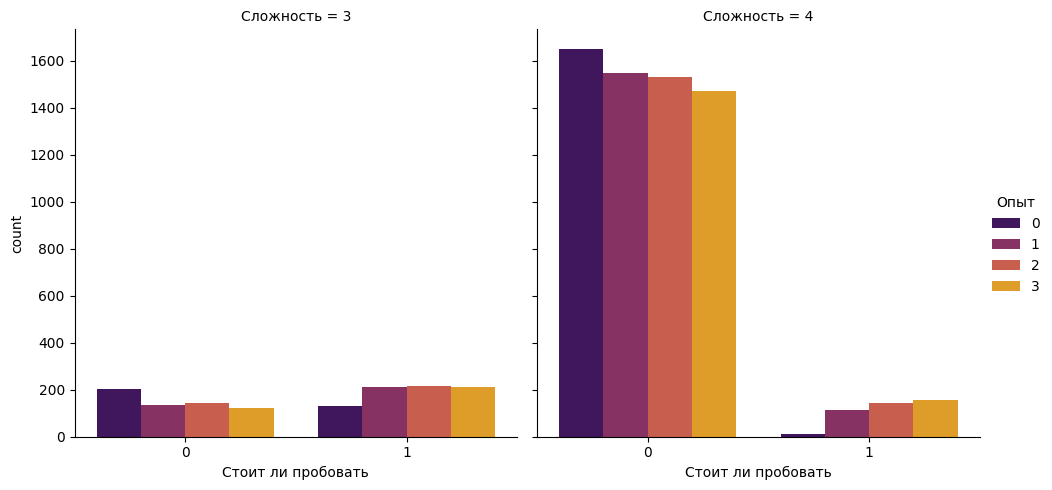

In [10]:
# Have only two numeric data, let's watch how its influence on target
sns.catplot(data=turns, x='Стоит ли пробовать', hue='Опыт', col='Сложность', kind='count', palette='inferno')
plt.show()

<Axes: xlabel='Сложность', ylabel='count'>

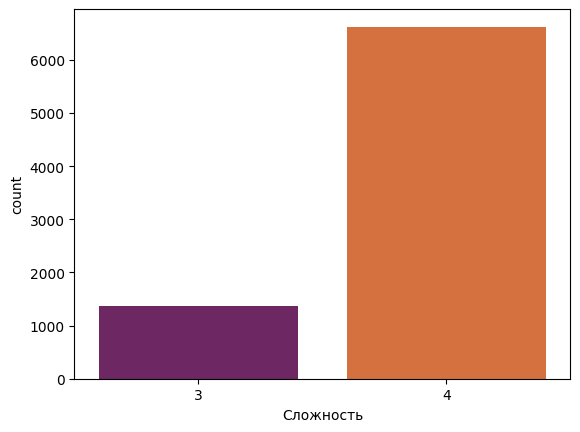

In [11]:
# Actually, do challenges with complexity(сложность) 4 are more often than with complexity 3?
# Yes! 
sns.countplot(data=turns, x='Сложность', palette='inferno')

In [12]:
# So, looking in previous graph. With more complexity it becomes less worth to take 
# the risky challenge, but experience become more helpful. Sounds logical
# Note that in this stage of the game 2 and 3 experience points give the same profit,
# so data might be different, and sometimes graphs will show that 2 experience points are 
# better than 3 points. But it's just coincidence, becauce of random choice of players and 
# turns from possible one

In [13]:
# Let's explore runes (руны)
turns['Руна_1'].unique()

array(['Телосложение', 'Ловкость', 'Сила', 'Мудрость', 'Обаяние',
       'Интеллект'], dtype=object)

In [14]:
turns['Руна_2'].unique()

array(['Мудрость', 'Сила', 'Интеллект', 'Телосложение', 'Обаяние',
       'Ловкость'], dtype=object)

In [15]:
turns['Основная руна'].value_counts()

Основная руна
Ловкость        1378
Телосложение    1342
Обаяние         1332
Мудрость        1331
Интеллект       1325
Сила            1292
Name: count, dtype: int64

In [16]:
# So we have in sum 6 runes in near the same quantity

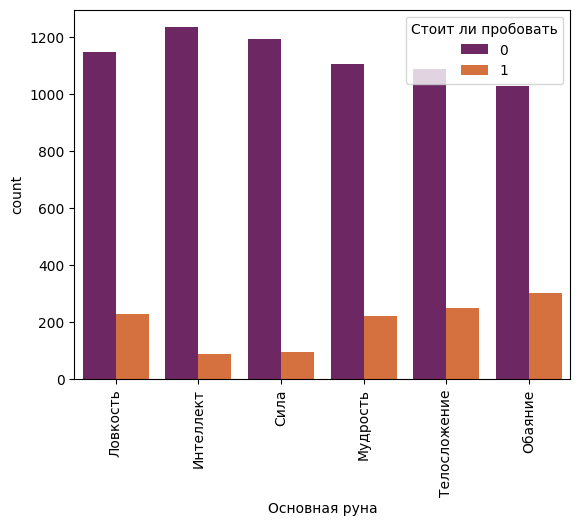

In [17]:
# With some of them challenges are simplier to take
sns.countplot(data=turns, x= 'Основная руна', hue = 'Стоит ли пробовать', palette='inferno')
plt.xticks(rotation=90);
plt.show()

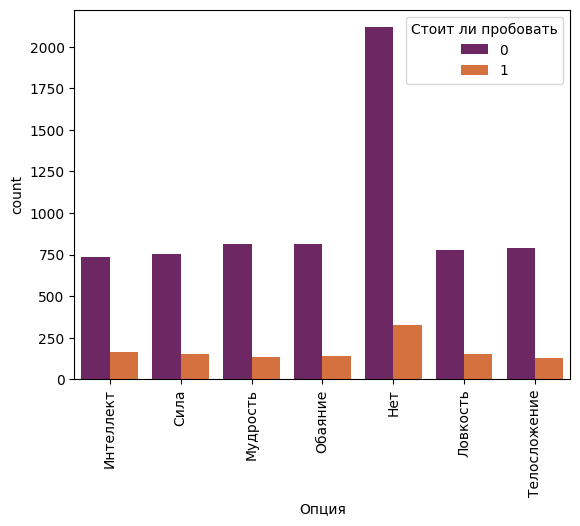

In [18]:
# Also we have 'Нет' option in category 'Опция'. But looks like it doesn't affect results much,
# positive result for this category bigger just because this category bigger itself
sns.countplot(data=turns, x= 'Опция', hue = 'Стоит ли пробовать', palette='inferno')
plt.xticks(rotation=90);
plt.show()

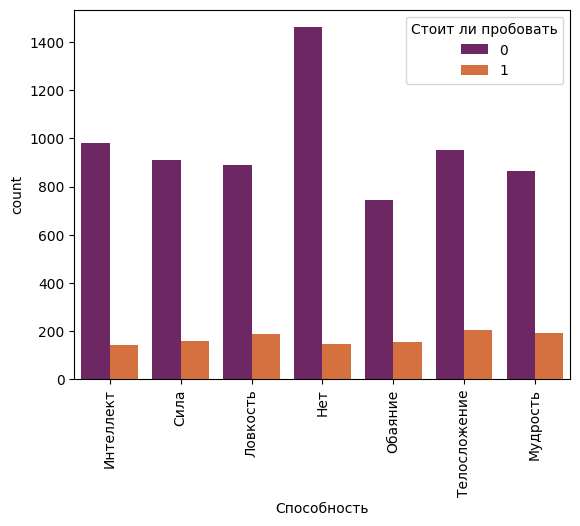

In [19]:
sns.countplot(data=turns, x= 'Способность', hue = 'Стоит ли пробовать', palette='inferno')
plt.xticks(rotation=90);
plt.show()

In [20]:
# Also we have two bool features, that are near the same "Использование дополнительной руны"
# and "Использование руны тьмы". But dark rune is a little bit simplier to get, it has less 
# requirements than extra rune. So as we see from three graohs below dark rune is more useful. 
# But what is even more good? Both of them at the same time. 
# I will not describe detailes about rune diffenece here, you may read about it 
# in "How to take challenge" section in README

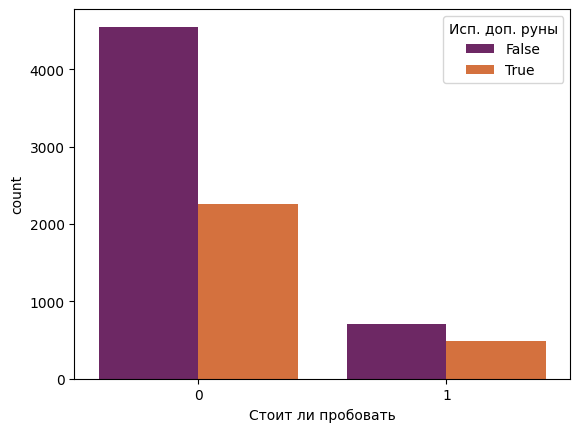

In [21]:
sns.countplot(data=turns, x= 'Стоит ли пробовать', hue = 'Исп. доп. руны', palette='inferno')
plt.show()

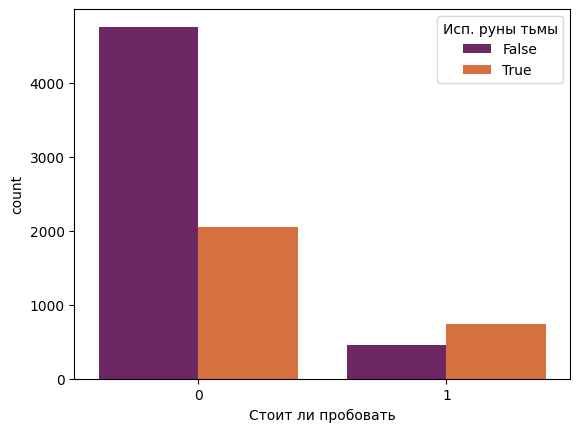

In [22]:
sns.countplot(data=turns, x= 'Стоит ли пробовать', hue = 'Исп. руны тьмы', palette='inferno')
plt.show()

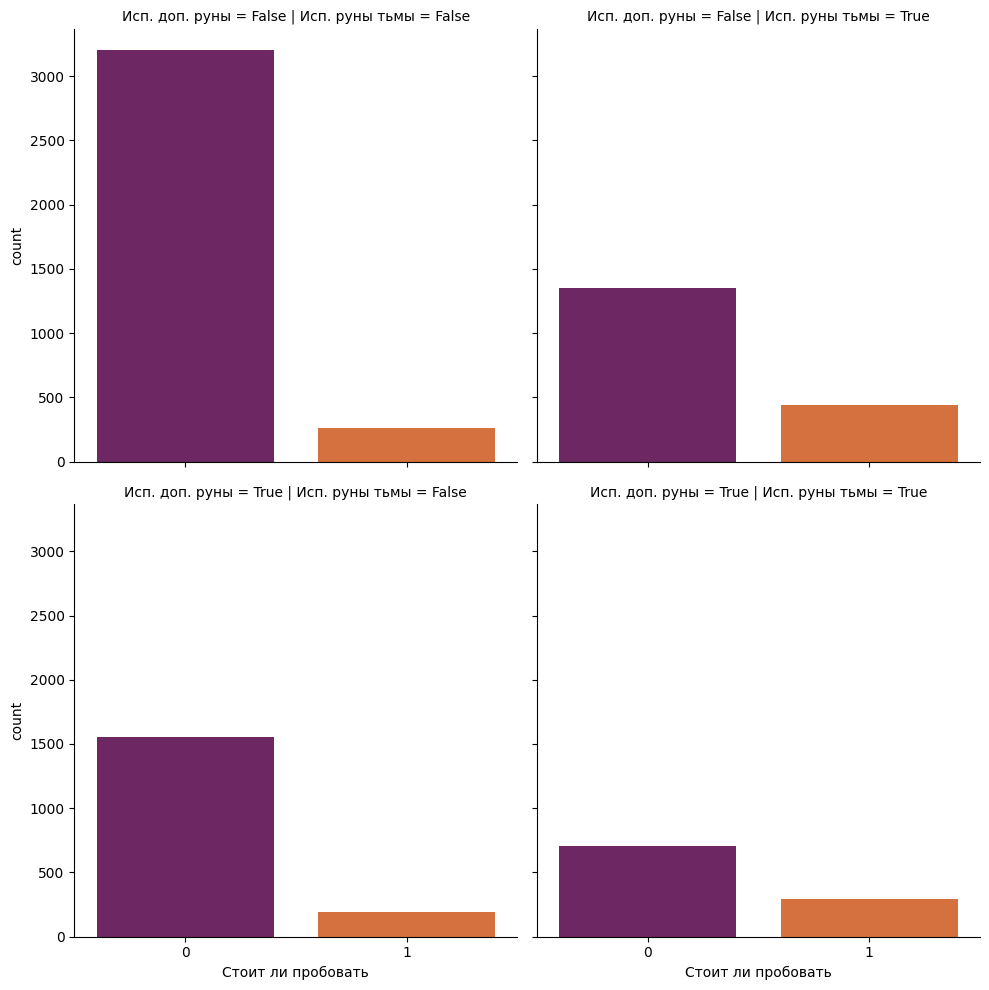

In [23]:
sns.catplot(x='Стоит ли пробовать',data=turns, kind='count',row='Исп. доп. руны',col='Исп. руны тьмы', palette='inferno')

In [24]:
# Data preprocessing
# Create list of categorical features and the main features that are different for every row, just contains some card names
features_cat = ["Руна_1", "Руна_2", "Опция", "Цель_1", "Цель_2", "Цель_3", "Основная руна",
                "Дополнительная руна", "Способность", "Исп. доп. руны", "Исп. руны тьмы"]
drops = ["Игрок", "Испытание", "Стоит ли пробовать", "Происхождение", "Стремление", "Судьба"]

In [25]:
# The following steps are involved:
# - Building dummies for the categorical columns
# - Assigning labels and targets
# - Lastly, splitting the test and training sets

In [26]:
df_turns = turns.copy()

In [27]:
# Creating dummy variables and deleting the previous column
for i in features_cat:
    turns[i] = turns[i].astype("category")
    dummy_df = pd.get_dummies(turns[i], prefix=i, drop_first=True, dtype=int)
    turns = pd.concat([turns, dummy_df], axis=1)
    turns = turns.drop(i, axis=1)
    
for i in ["Опыт", "Сложность","Стоит ли пробовать"]:
    turns[i] = turns[i].astype(int)
    
X = turns.drop(drops, axis=1)
y = turns["Стоит ли пробовать"]

In [28]:
# Closer look on features now
X.head()

,Опыт,Сложность,Руна_1_Ловкость,Руна_1_Мудрость,Руна_1_Обаяние,Руна_1_Сила,Руна_1_Телосложение,Руна_2_Ловкость,Руна_2_Мудрость,Руна_2_Обаяние,...,Дополнительная руна_Сила,Дополнительная руна_Телосложение,Способность_Ловкость,Способность_Мудрость,Способность_Нет,Способность_Обаяние,Способность_Сила,Способность_Телосложение,Исп. доп. руны_True,Исп. руны тьмы_True
0,3,4,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,3,4,0,0,0,1,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1
3,3,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,4,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [29]:
X_trains, X_valid, y_trains, y_valid = train_test_split(X, y, test_size=0.10, random_state=101)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_trains, y_trains, test_size=0.20, random_state=101)

In [31]:
X_train

,Опыт,Сложность,Руна_1_Ловкость,Руна_1_Мудрость,Руна_1_Обаяние,Руна_1_Сила,Руна_1_Телосложение,Руна_2_Ловкость,Руна_2_Мудрость,Руна_2_Обаяние,...,Дополнительная руна_Сила,Дополнительная руна_Телосложение,Способность_Ловкость,Способность_Мудрость,Способность_Нет,Способность_Обаяние,Способность_Сила,Способность_Телосложение,Исп. доп. руны_True,Исп. руны тьмы_True
998,2,3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4030,0,3,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2835,0,3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
177,2,4,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1694,3,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149,3,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
432,3,4,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4942,1,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1016,1,4,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [32]:
# Model selection
# My main was to use the second data division(_train and _test) for testing different model, 
# than use _trains for gridsearchCV for best parameters for one choosed model
# So will create pipeline for some model and see how it works
## Remember that we have unbalanced data ##

In [33]:
# Before start let's write small function to get sample weights
# It's important to not forget about weights because we have imbalanced data and not all 
# model and metrics use weights without command
def retrun_sample_weight(y_test):
    return class_weight.compute_sample_weight(
    class_weight={0: 1, 1: round((y == 0).sum() / (y == 1).sum())},
    y = y_test
)

In [34]:
# Building pipelines for model selection

pipeline_lr=Pipeline([("scaler1",StandardScaler()),
                      ("LR",LogisticRegressionCV(class_weight='balanced'))])

pipeline_rf=Pipeline([("scaler2",StandardScaler()),
                      ("RF",RandomForestClassifier(class_weight='balanced'))])

pipeline_knn=Pipeline([("scaler3",StandardScaler()),
                       ("pca1",PCA(n_components=40)),
                       ("KNN",KNeighborsClassifier(n_neighbors=5, weights='distance'))])

pipeline_xgb=Pipeline([("XGB",XGBClassifier(scale_pos_weight = (y == 0).sum() / (y == 1).sum()))])

pipeline_cat=Pipeline([("CatBoost",CatBoostClassifier(auto_class_weights='Balanced', silent=True))])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_rf, pipeline_knn, pipeline_xgb, pipeline_cat]
pipe_dict = {0: "LogisticRegression", 1: "RandomForest", 2: "KNeighbors", 3: "XGBClassifier", 4: "CatBoostClassifier"}

In [35]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    
results = []
for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred) #, sample_weight=retrun_sample_weight(y_test))
    results.append(f1)
    print("%s: %f " % (pipe_dict[i], f1))

# I choosed f1-score as a parameter to balance between precision and recall, so to maximize
# chance that you will not take some realy risk challenge, but at the same time not miss a simple one
# CatBoostClassifier shows a better performance than other models, so will do gridsearch for it
# Also XGBClassifier shows good performance, so may explore it too

LogisticRegression: 0.561205 
RandomForest: 0.656716 
KNeighbors: 0.550000 
XGBClassifier: 0.798186 
CatBoostClassifier: 0.801724 


In [36]:
# Let's start with XGBClassifier. Just because it's some standard and simple grid search
# Choose parameters and its variants
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 1, 10]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                    scale_pos_weight = (y == 0).sum() / (y == 1).sum())

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',  # Use 'roc_auc' for imbalanced datasets
    cv=5,  
    n_jobs=-1,  
    verbose=2
)

# Fit the model
grid_search_xgb.fit(X_trains, y_trains)

# Best parameters and score
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 0.1}
Best Score: 0.9786226424879455


In [37]:
# Get predictions from best model and plot classification report
y_pred_xgb = grid_search_xgb.predict(X_valid)
print(classification_report(y_valid, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       684
           1       0.86      0.84      0.85       116

    accuracy                           0.96       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.96      0.96      0.96       800



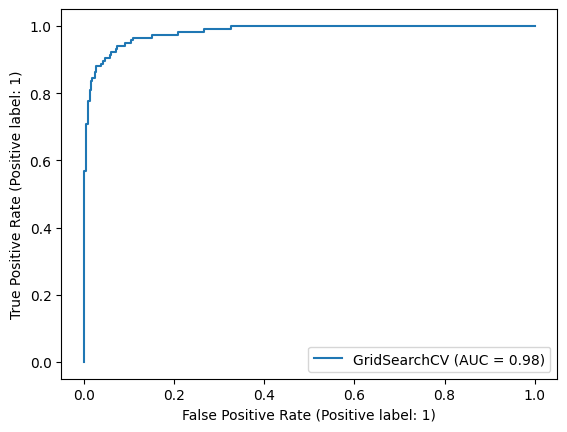

In [38]:
# Plot ROC curve and count AUC. The closer its for 1 the better is model. 
# Way to undestand is our model is good in balancing True Positive and False Positive
RocCurveDisplay.from_estimator(grid_search_xgb, X_valid, y_valid, pos_label=grid_search_xgb.classes_[1])

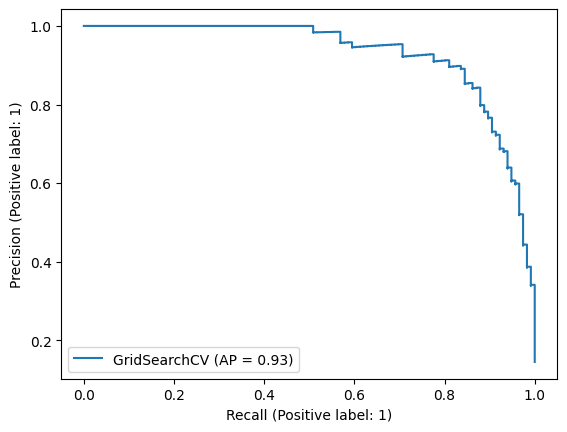

In [39]:
# Because we have imbalanced data let's plot also precision-recall curve
# It's more reseprentative for imbalanced classes. And we see area under the curve for this one
# is less than for ROC curve. But still good enough
PrecisionRecallDisplay.from_estimator(grid_search_xgb, X_valid, y_valid)

In [40]:
# Now let's explore catboost

In [41]:
# Graphics style change

In [42]:
%%html
<style>
.catboost {
    filter: invert(1);
    color: black;
    background-color: white;
}
</style>

In [43]:
# Firsty, CatBoost doesn't need all this categorical features preparations. It may do it automatically,
# with just knowledge which column is categorical. 
# But I already did all preparation and compare model on the same dataset and samples. 
# So I won't change data preprocessing, but in future it may be something to explore

In [44]:
# First attempt
# CatBoost has option to plot testing result in real time
# Actually the best iteration is before 400, so we don't need all this iterations
# For such a small dataset it's not such a big problem, but it may be long for large 
# datasets or cause overfitting(?)
cat1 = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric= 'F1',
    auto_class_weights='Balanced',
    logging_level='Silent'
)

cat1.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    # logging_level='Verbose',  
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
# Let's use the best model and stop our training earlier, if don't have progress in 50 iterations
# This model will use less trees
cat2 = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric= metrics.F1(),
    auto_class_weights='Balanced',
    logging_level='Silent',
    iterations=1000,
    use_best_model=True,
    od_type='Iter',
    od_wait=50
)

cat2.fit(
    X_train, y_train,
    eval_set=(X_test, y_test), 
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [46]:
# Now get predictions and classification report for f1_score for class_1
y_pred = cat2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1238
           1       0.69      0.94      0.80       202

    accuracy                           0.93      1440
   macro avg       0.84      0.93      0.88      1440
weighted avg       0.95      0.93      0.94      1440



In [47]:
# Wait, what?
# In classification report we have f1 score for both class, but none of them is 0.91 - number on training plot
# Actually, it because we use weights for CatBoostClassifier. It automatically count f1 with those wweights.
# In all other characteristics calculation we need to chose use weights manually.

In [48]:
# With usage of weights we get the same result for both classes. But know support is not rows quantity, 
# but samples with weights
print(classification_report(y_test, y_pred, sample_weight=retrun_sample_weight(y_test)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93    1238.0
           1       0.93      0.94      0.93    1212.0

    accuracy                           0.93    2450.0
   macro avg       0.93      0.93      0.93    2450.0
weighted avg       0.93      0.93      0.93    2450.0



In [49]:
# Whitout using sample weights we may see in classification report the actual distribution 
# of the data, not hte weighted version. All this metrics already defined for exact class, 
# so it's a bit irrational to calculate their weighted versions.
# Also we used weights on training to show model, that important class is smaller, so why 
# use them for evaluation
# But the most simple reason is that it's simplier to interpret results without weights on metrics
# If you calculate metrics on yourown from confusion matrix, you will get version with no weigths

In [50]:
# We may change f1 in CatBoost to get the same result on plot as in the classification report
cat3 = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric= metrics.F1(use_weights=False),
    auto_class_weights='Balanced',
    logging_level='Silent',
    iterations=1000,
    use_best_model=True,
    od_type='Iter',
    od_wait=50
)

cat3.fit(
    X_train, y_train,
    eval_set=(X_test, y_test), 
    plot=True
);

y_pred = cat3.predict(X_test)
print(classification_report(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1238
           1       0.76      0.91      0.83       202

    accuracy                           0.95      1440
   macro avg       0.87      0.93      0.90      1440
weighted avg       0.95      0.95      0.95      1440



In [51]:
# Note! CatBoost doesn't like that I turned off sample weights for evaluation metric. For 
# simple training it's still work. But with cross validation it wil show an error. So to compare model
# with using cross validation on CatBoost sample weights needed everywhere

In [52]:
param_grid = {
    'iterations': [100, 200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 10]
}

# Initialize the CatBoost classifier
cat = CatBoostClassifier(eval_metric=metrics.F1(use_weights=False),
    verbose=False, loss_function=metrics.Logloss(),
    auto_class_weights='Balanced'
)

# Set up GridSearchCV
grid_search_cat = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    scoring='roc_auc', 
    cv=5,  
    n_jobs=-1,  
    verbose=2
)

# Fit the model
grid_search_cat.fit(X_trains, y_trains)

# Best parameters and score
print("Best Parameters:", grid_search_cat.best_params_)
print("Best Score:", grid_search_cat.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best Parameters: {'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.2, 'max_depth': 4}
Best Score: 0.9844290303517329


In [53]:
# It's good but still worse than xgboost
y_pred_cat = grid_search_cat.predict(X_valid)
print(classification_report(y_valid, y_pred_cat))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       684
           1       0.78      0.90      0.84       116

    accuracy                           0.95       800
   macro avg       0.88      0.93      0.90       800
weighted avg       0.95      0.95      0.95       800



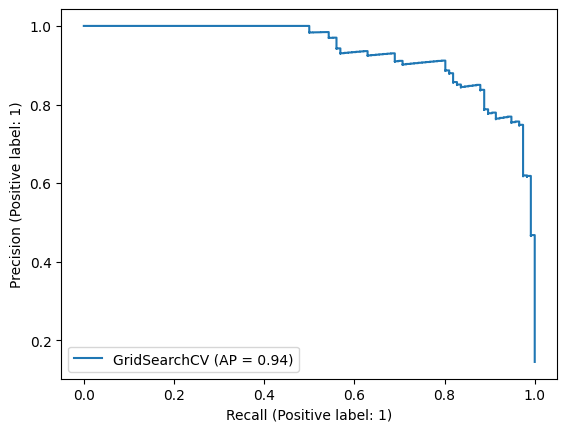

In [54]:
PrecisionRecallDisplay.from_estimator(grid_search_cat, X_valid, y_valid)

In [55]:
# "Сложность" and "Исп. руны тьмы" are the most important features that we had. 
# For complexoty it's actually logical, we have this parameter in every turn, but the other contains runes, 
# so have now six features for one original column
# For dark rune it's also logical we saw, while exploring data, that usage of dark rune give 
# significante advantage of taking the challenge

# Also will be more intresting to watch on features importances if I didn't use dummy variables it's possible for CatBoost

In [56]:
features = pd.DataFrame(index=X.columns,data=grid_search_cat.best_estimator_.feature_importances_,
                        columns=['Feature Importance']).sort_values('Feature Importance',ascending=False)

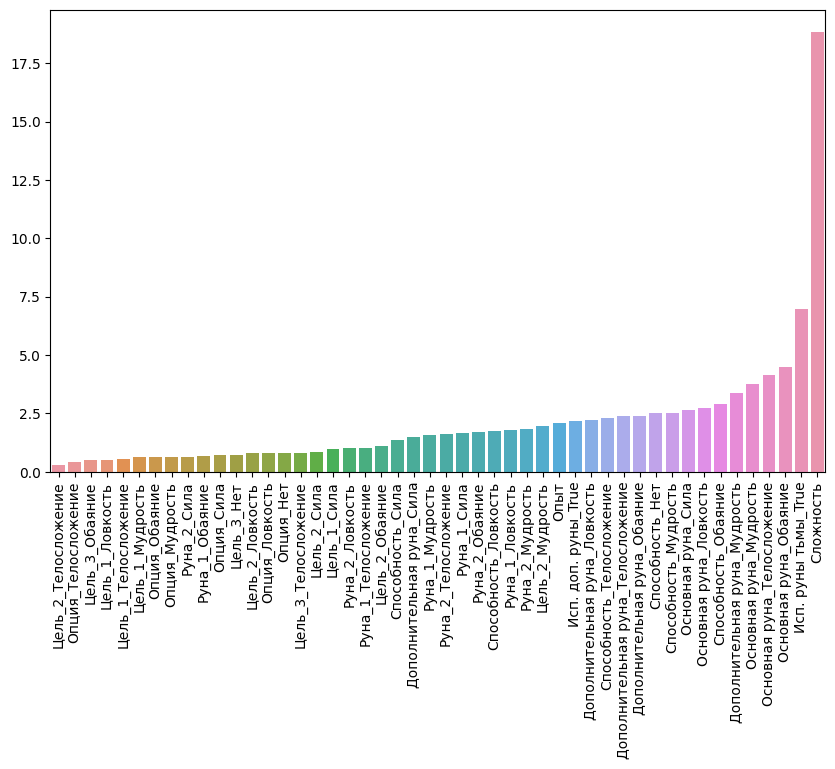

In [57]:
feats = pd.Series(index=X.columns,data=features['Feature Importance'])
feats = feats.sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=feats.index,y=feats.values)
plt.xticks(rotation=90);

In [58]:
final_model = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=500,
                           objective='binary:logistic', reg_lambda=1,
                           eval_metric='logloss', scale_pos_weight = (y == 0).sum() / (y == 1).sum())
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [59]:
# Save final version of our model 
final_model.save_model("xgboost_model.json")

In [60]:
# Train final version of our model on all dataset
# final_model = CatBoostClassifier(
#     loss_function='Logloss',
#     eval_metric= metrics.F1(use_weights=False),
#     auto_class_weights='Balanced',
#     logging_level='Silent',
#     iterations=400, 
#     l2_leaf_reg=10,
#     learning_rate=0.2, 
#     max_depth=4
# )

# final_model.fit(
#     X, y,
#     plot=True
# );


In [61]:
# final_model.save_model('catboost_model.bin')

In [62]:
# Look another file to find a usage of this model) 